In [1]:
# Sartorius

import numpy as np
import pandas as pd
import random
from glob import glob
# visualization
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# BASE_PATH  = '/kaggle/input/sartorius-cell-instance-segmentation'
BASE_PATH  = '.'

# Train Data

In [3]:

df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = BASE_PATH + '/train/' + df['id'] + '.png'
tmp_df = df.drop_duplicates(subset=["id", "image_path"]).reset_index(drop=True)
tmp_df["annotation"] = df.groupby("id")["annotation"].agg(list).reset_index(drop=True)
df = tmp_df.copy()
df.head(3)

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta,image_path
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,./train/0030fd0e6378.png
1,0140b3c8f445,[32499 3 33201 7 33902 9 34604 10 35306 11 360...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_F8-3_Vessel-361_Ph_4,0 days 09:00:00,./train/0140b3c8f445.png
2,01ae5a43a2ab,[241026 3 241726 9 242427 13 243130 14 243834 ...,704,520,cort,13h30m00s,2020-11-04,cort[oka-high]_B5-1_Vessel-377_Ph_1,0 days 13:30:00,./train/01ae5a43a2ab.png


# Test Data

In [4]:

test_df = pd.DataFrame(glob(BASE_PATH+'/test/*'), columns=['image_path'])
test_df['id'] = test_df.image_path.map(lambda x: x.split('/')[-1].split('.')[0])

print(test_df.head(3))

                image_path                 id
0  ./test\7ae19de7bc2a.png  test\7ae19de7bc2a
1  ./test\d48ec7815252.png  test\d48ec7815252
2  ./test\d8bfd1dafdc4.png  test\d8bfd1dafdc4


## Class Distribution

<AxesSubplot:>

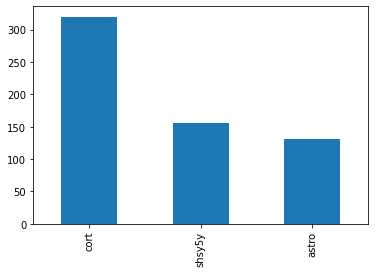

In [5]:
df.cell_type.value_counts().plot.bar()

In [6]:
df.head(606)

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta,image_path
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 ...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00,./train/0030fd0e6378.png
1,0140b3c8f445,[32499 3 33201 7 33902 9 34604 10 35306 11 360...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_F8-3_Vessel-361_Ph_4,0 days 09:00:00,./train/0140b3c8f445.png
2,01ae5a43a2ab,[241026 3 241726 9 242427 13 243130 14 243834 ...,704,520,cort,13h30m00s,2020-11-04,cort[oka-high]_B5-1_Vessel-377_Ph_1,0 days 13:30:00,./train/01ae5a43a2ab.png
3,026b3c2c4b32,[170753 5 171454 12 172158 13 172862 13 173565...,704,520,cort,19h30m00s,2020-11-04,cort[oka-low]_H6-2_Vessel-377_Ph_2,0 days 19:30:00,./train/026b3c2c4b32.png
4,029e5b3b89c7,[139142 7 139845 10 140548 13 141251 15 141955...,704,520,cort,13h30m00s,2020-10-27,cort[pre-treat]_B8-2_Vessel-377_Ph_2,0 days 13:30:00,./train/029e5b3b89c7.png
...,...,...,...,...,...,...,...,...,...,...
601,fd98d82784a1,[335979 1 336681 3 337385 3 338088 3 338792 3 ...,704,520,astro,13h00m00s,2020-09-14,astro[hippo]_G1-4_Vessel-361_Ph_3,0 days 13:00:00,./train/fd98d82784a1.png
602,fe33dfcf4ebd,[165826 7 166526 14 167199 45 167901 46 168603...,704,520,astro,13h00m00s,2020-09-15,astro[hippo]_F2-4_Vessel-361_Ph_1,0 days 13:00:00,./train/fe33dfcf4ebd.png
603,fe3e30f849f4,[343210 3 343912 4 344610 9 345312 10 346014 1...,704,520,shsy5y,11h30m00s,2019-06-15,shsy5y[diff]_D10-4_Vessel-714_Ph_3,0 days 11:30:00,./train/fe3e30f849f4.png
604,ffc2ead3e8cc,[252827 1 253531 3 254235 5 254940 5 255644 7 ...,704,520,astro,09h00m00s,2020-09-13,astros[cereb]_F11-4_Vessel-361_Ph_1,0 days 09:00:00,./train/ffc2ead3e8cc.png


# Dataset

In [7]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.img_paths  = df['image_path'].values
        self.annotation = df['annotation'].values
        self.cell_type = df['cell_type'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        if self.transforms:
            img = self.transforms(img)
        else:
            img = img
        annotation = str(self.annotation[index])
        cell_type = self.cell_type[index]
            # img  = data['image']
        return img, annotation, cell_type

# Augmentations

In [8]:
#data Augumentation
transformations =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        
    ])

# DataLoader

In [9]:
def prepare_loaders(batch_size, split=0.7):
    train_df = df.iloc[:int(len(df) * split)]
    valid_df = df.iloc[int(len(df) * split):]
    
    train_dataset = BuildDataset(train_df, transforms=transformations)
    valid_dataset = BuildDataset(valid_df, transforms=transformations)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader


In [10]:
train_loader, valid_loader = prepare_loaders(batch_size=64)

In [ ]:
imgs, annotations, cell_types = iter(train_loader).next()
imgs = imgs.permute((0, 2, 3, 1))
imgs.size()

# Visualization

In [ ]:
def plot_batch(imgs, annotations, cell_types, size=3):
    for idx in range(size):
        plt.figure(figsize=(4*3, 5))

        plt.imshow(imgs[idx])
        plt.title(f'cell_types: {cell_types[idx]}', fontsize=15)
        plt.axis('OFF')
        print(f'annotations first 10: {annotations[idx][:10]}')
        plt.tight_layout()
        plt.show()

In [ ]:
plot_batch(imgs, annotations, cell_types, size=3)